<a href="https://colab.research.google.com/github/barbaraluizaoliveira/projeto-final-telos/blob/main/C%C3%B3pia_de_projeto_final_t%C3%A9los.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Dados para Priorização Inteligente de Vulnerabilidades
#### Este notebook explora as limitações da priorização de vulnerabilidades baseada em CVSS através de uma análise prática de dados. Utilizando datasets públicos da NVD, CISA KEV e EPSS, esta análise demonstra que a maioria das CVEs "Críticas" (CVSS) nunca é explorada, enquanto ameaças reais (KEV) e prováveis (EPSS) são frequentemente negligenciadas. O objetivo é construir o caso de uso, baseado em dados, para um sistema de priorização inteligente que foca no que é explorado e no que será explorado, não apenas no que é teoricamente severo.

### 1. Configuração, Ferramentas e Carregamento de Dados 📚

Nesta etapa, importamos as bibliotecas necessárias para a análise (Pandas, Matplotlib, Seaborn) e carregamos nossos três datasets principais:

- NVD: O catálogo completo de vulnerabilidades (nossa "base").
- CISA KEV: A lista de ameaças ativamente exploradas (o "risco real").
- EPSS: A pontuação de probabilidade de exploração (o "risco preditivo").

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_cisa_kev_nvd = pd.read_csv('/content/nvd_join_cisa_kev.csv', low_memory=False)
file_cisa_kev_nvd.head()


,id_cve,explorada_ativamente,pontuacao_cvss_v3,gravidade_do_cvss_v3,data_publicacao,kev_data_inclusao,kev_prazo_limite,kev_prazo_dias,kev_ransomware,kev_fabricante,...,status_vulnerabilidade,vetor_de_ataque,complexidade_de_ataque,privileges_required,interção_do_usuario,impacto_da_confidencialidade,impacto_na_integridade,impacto_da_disponibilidade,pontuacao_de_explorabilidade_v3,pontuacao_de_impacto_v3
0,CVE-2020-14871,SIM - Explorada (KEV),10,CRITICAL,21/10/2020,11/3/2021,5/3/2022,181.0,Unknown,Oracle,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,"3,9",6
1,CVE-2021-22893,SIM - Explorada (KEV),10,CRITICAL,23/04/2021,11/3/2021,23/04/2021,-194.0,Known,Ivanti,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,"3,9",6
2,CVE-2021-22205,SIM - Explorada (KEV),10,CRITICAL,23/04/2021,11/3/2021,17/11/2021,14.0,Known,GitLab,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,"3,9",6
3,CVE-2021-28799,SIM - Explorada (KEV),10,CRITICAL,13/05/2021,31/03/2022,21/04/2022,21.0,Known,QNAP,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,"3,9",6
4,CVE-2021-30116,SIM - Explorada (KEV),10,CRITICAL,9/7/2021,11/3/2021,17/11/2021,14.0,Known,Kaseya,...,Analyzed,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,"3,9",6


# Coletando Insingths
#### 1. Qual é a verdadeira taxa de exploração de vulnerabilidades críticas?
Das milhares de CVEs críticas (CVSS 9.0+) que identificamos, qual a porcentagem exata que está na lista de "Exploradas Ativamente" (CISA KEV)?


In [35]:
file_cisa_kev_nvd['pontuacao_cvss_v3'] = pd.to_numeric(
    file_cisa_kev_nvd['pontuacao_cvss_v3'].astype(str).str.replace(',', '.'),
    errors='coerce'
)

df_criticas = file_cisa_kev_nvd[file_cisa_kev_nvd['pontuacao_cvss_v3'] >= 9.0]

total_criticas = df_criticas.shape[0]

criticas_no_kev = df_criticas['kev_data_inclusao'].notna().sum()

if total_criticas > 0:
    percentual_kev = (criticas_no_kev / total_criticas) * 100
else:
    percentual_kev = 0

print(f"Total de CVEs 'Críticas' (CVSS 9.0+): {total_criticas}")
print(f"Total de 'Críticas' que estão no KEV: {criticas_no_kev}")
print(f"Percentual de 'Críticas' exploradas: {percentual_kev:.1f}%")

Total de CVEs 'Críticas' (CVSS 9.0+): 17117
Total de 'Críticas' que estão no KEV: 285
Percentual de 'Críticas' exploradas: 1.7%


#### 1.1 Proporção de CVEs críticas (CVSS 9.0+) \ ativamente exploradas vs. não exploradas

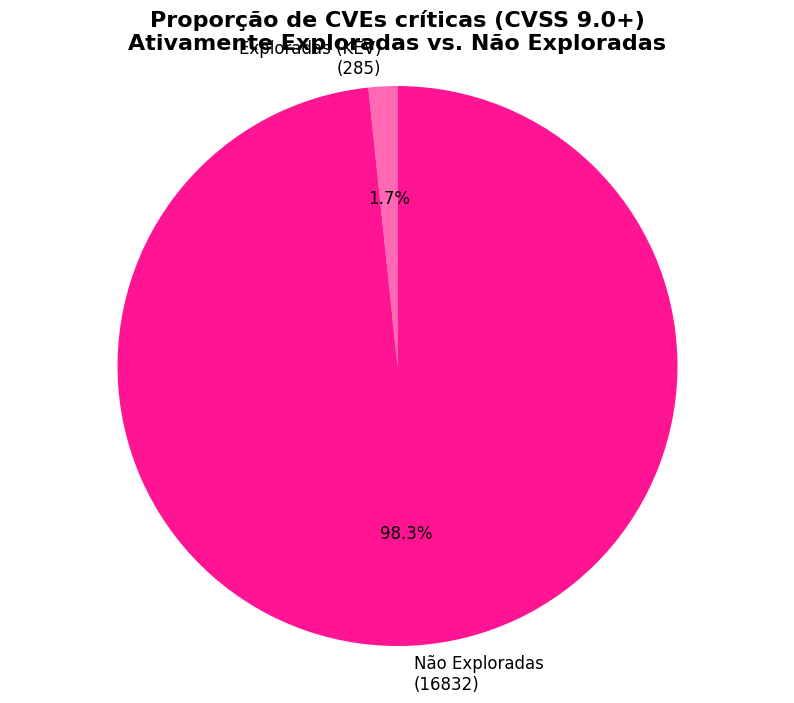

In [36]:
criticas_nao_kev = total_criticas - criticas_no_kev

valores = [criticas_no_kev, criticas_nao_kev]
labels = [
    f'Exploradas (KEV)\n({criticas_no_kev})',
    f'Não Exploradas\n({criticas_nao_kev})'
]
cores = ['#FF69B4', '#FF1493']

plt.figure(figsize=(10, 8))
plt.pie(
    valores,
    labels=labels,
    colors=cores,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12}
)
plt.title('Proporção de CVEs críticas (CVSS 9.0+)\nAtivamente Exploradas vs. Não Exploradas', fontsize=16, weight='bold')
plt.axis('equal')
plt.savefig('etapa2_pergunta1_taxa_exploracao_criticas.png')

#### 2. O Perigo Oculto: 64% das ameaças reais não são críticas

Agora que provamos que focar em críticos é ineficiente (gera 98,3% de ruído), vamos provar que também é perigoso.

Se o método antigo foca apenas em críticos, ele pelo menos captura as ameaças que realmente importam? O código abaixo analisa a composição da lista CISA KEV para descobrir o perfil de severidade das vulnerabilidades que estão realmente sendo exploradas.

In [37]:
df_apenas_kev = file_cisa_kev_nvd[esta_no_kev]

distribuicao_kev_contagem = df_apenas_kev['gravidade_do_cvss_v3'].value_counts()
distribuicao_kev_percent = df_apenas_kev['gravidade_do_cvss_v3'].value_counts(normalize=True) * 100

dist_kev_df = pd.DataFrame({
    'Total na KEV': distribuicao_kev_contagem,
    'Porcentagem (%)': distribuicao_kev_percent
}).sort_values(by='Total na KEV', ascending=False)

print(dist_kev_df)

nao_criticas_no_kev = dist_kev_df.drop('CRITICAL', errors='ignore')['Total na KEV'].sum()
percent_nao_criticas = dist_kev_df.drop('CRITICAL', errors='ignore')['Porcentagem (%)'].sum()
print(f"\nTotal de ameaças no KEV que não são críticas: {nao_criticas_no_kev:.0f} ({percent_nao_criticas:.1f}%)")

                      Total na KEV  Porcentagem (%)
gravidade_do_cvss_v3                               
HIGH                           395        49.313358
CRITICAL                       285        35.580524
MEDIUM                         114        14.232210
LOW                              7         0.873908

Total de ameaças no KEV que não são críticas: 516 (64.4%)


#### 2.1 Gráfico do Perfil de Severidade KEV

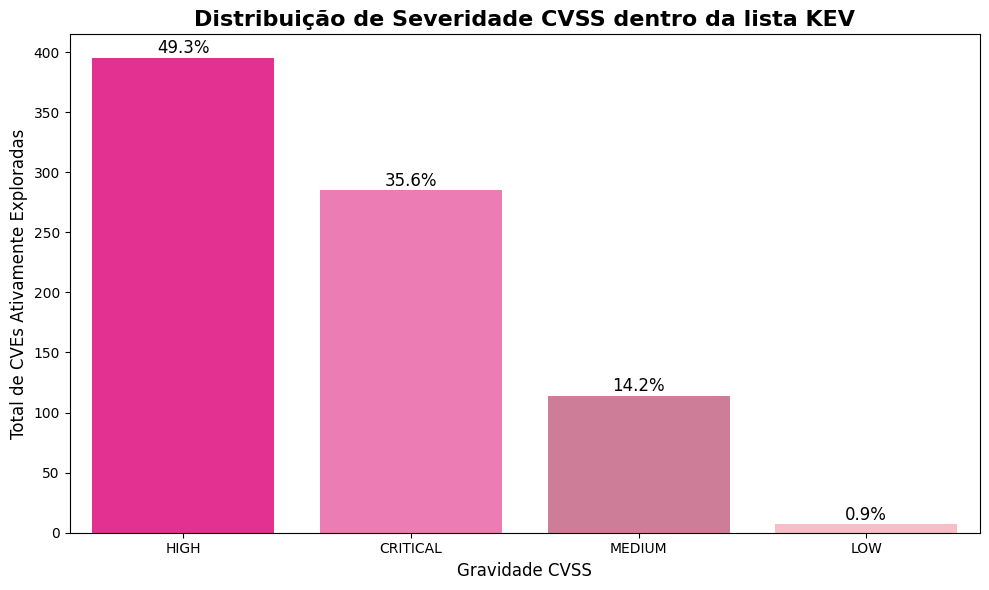

In [39]:
cores_insight_2 = ['#FF1493', '#FF69B4', '#DB7093', '#FFB6C1']

plt.figure(figsize=(10, 6))
ax_kev = sns.barplot(
    x=dist_kev_df.index,
    y=dist_kev_df['Total na KEV'],
    palette=cores_insight_2,
    hue=dist_kev_df.index,
    legend=False
)
plt.title('Distribuição de Severidade CVSS dentro da lista KEV', fontsize=16, weight='bold')
plt.xlabel('Gravidade CVSS', fontsize=12)
plt.ylabel('Total de CVEs Ativamente Exploradas', fontsize=12)

for i, p in enumerate(ax_kev.patches):
    percentage = f"{dist_kev_df['Porcentagem (%)'].iloc[i]:.1f}%"
    ax_kev.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 7),
                textcoords='offset points')

plt.tight_layout()
plt.savefig('etapa2_pergunta2_distribuicao_kev_cores_novas.png')